# **0. Explanation**
마지막 과제에 오신 것을 환영합니다. 이번 과제는 자유 주제 토이 프로젝트 진행입니다.

아무런 가이드 없이 프로젝트를 진행하는 것은 어려우니, 실제 진행했던 토이 프로젝트를 설명과 함께 예시로 제시합니다.

# **1. Dataset selection**
사실 소규모 프로젝트를 진행함에 있어 제일 중요한 부분은 주제의 참신성/재미보다는 데이터가 있는지입니다. 데이터의 존재 유무, 데이터의 크기 등을 고려해야 합니다. 데이터를 찾을 수 있는 사이트 몇 개는 다음과 같습니다.

1. AI-Hub: https://www.aihub.or.kr/
2. Kaggle: https://www.kaggle.com/datasets
3. 국립국어원 말뭉치 : https://ithub.korean.go.kr/user/total/database/corpusManager.do

종합적으로 정리된 사이트: https://littlefoxdiary.tistory.com/42

데이터가 존재한다면, 이제 데이터의 용량을 봅니다.
극단적으로 큰 데이터를 사용한다면 시간 내 제출이 어려울 수 있습니다.

NLP로는 그렇게 큰 데이터가 많지 않습니다. 원활한 진행을 위해 아주 크게 가더라도 10GB 정도를 마지노선으로 생각해 주세요. 오랜 시간 훈련시켰는데 훈련이 실패하거나 에러가 있었던 것을 깨닫게 될 때의 기분은... 모르시는 게 좋습니다.

다양한 데이터셋을 보면서 관심이 가고 관심 분야의 주제와 관련된 데이터셋을 한 번 찾아보세요.
이 과제에서 이용한 데이터셋은 AIHub의 에세이 글 평가 데이터입니다.
(https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=545)


# **2. Topic selection**
1번과 직접적으로 이어지는 과정입니다.

이제 본인이 연구하고 싶은 주제/만들고 싶은 서비스는 무엇인지를 고민합니다.
개인적으로는 이 과정이 실제 프로젝트에 있어 항상 후회되던 부분이었습니다.
조금만 더 고민해보면 동일한 문제를 해결하는 더 좋은 방법이 있거나 해결의 필요성이 없는 주제가 많았습니다.

NLP와는 무관하지만 이런 예시를 들 수 있습니다.
한 경진대회에서 저는 '점자로 쓰인 글 축약'을 위한 프로젝트를 진행하고 있었습니다. 고민하고 모델 구조를 떠올린 이후 이런 생각이 들었습니다.
'점자 축약이 오디오북보다 나은 점이 뭐지?' 끝내 그 질문에 대한 합리적인 대답을 내놓기는 어려워서, 다른 주제로 틀어야만 했습니다.

이번 과제는 어디까지나 과제이기도 하고, 뭐라도 만들어보는 것을 목표로 합니다.
따라서 아주 진지한 고민을 할 필요는 없지만, 꼭 기억해두시면 언젠가 필요할 때 도움이 될 것입니다.



# **3. Data analysis**
이제는 데이터셋을 불러온 후, 데이터를 분석합니다. 이상치 제거나 모델 선정에 영향을 미칩니다.

나아가 사실상 모델의 변경보다 전처리를 잘 하는게 성능에 **매우** 중대한 영향을 미칩니다.

반드시 기억해주세요.

In [ ]:
# 코랩을 이용한다면 자료를 직접 올리는 것보다 드라이브에 마운트하고 드라이브에서 받아오는 게 더 빠릅니다.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import
from transformers import ElectraForSequenceClassification, ElectraTokenizer,Trainer, TrainingArguments,utils
import torch
import json
import random
import torch.cuda
import os

In [ ]:
# 그렇지만 개인적으로는 캐글을 추천합니다. 캐글에 데이터셋을 올리고 캐글에서 가져오는 것이 여러모로 편하고 빠릅니다.
# 아시겠지만, os.listdir로 특정 direction의 하위 direcrtion을 모두 가져올 수 있습니다.
td='/kaggle/input/score-data/TL_/주장/'
vd='/kaggle/input/score-data/VL_/주장/'
train_dir=[td+i for i in os.listdir('/kaggle/input/score-data/TL_/주장')]
val_dir=[vd+i for i in os.listdir('/kaggle/input/score-data/VL_/주장')]

# AIHub에서 제공한 validation data가 너무 많아 일부를 추출하여 training data로 이용하고자 했습니다.
val_to_train=[val_dir[i] for i in random.sample(range(0,1488),488)]
val_dir=[i for i in val_dir if i not in val_to_train]
train_dir=train_dir+val_to_train

In [ ]:
# 먼저 데이터를 한번 print 찍어봅니다. 큰 데이터의 경우 pprint를 이용해도 좋습니다.
 with open(train_dir[100], encoding='utf-8-sig') as train:
        train = json.load(train)
        print(train)

In [ ]:
# Train dataset과 validation dataset을 만들기 시작합니다.
# json 파일을 이용하게 될 경우가 많을텐데, encoding에 주의해 주세요. 한글이라면 utf-sig-8을 주로 이용합니다.
# json 파일의 구조가 헷갈릴 수 있습니다. 참고할 만한 사이트를 첨부합니다.
# https://www.daleseo.com/python-json/
train_dataset=[]
val_dataset=[]

# train data/validation data에 이용한 dir에 대해서 json 파일을 열고, data를 (문단 내용, 글 점수)로 구성합니다.
# +0.5를 하는 것은 반올림을 위한 것입니다.
for i in train_dir:
    with open(i, encoding='utf-8-sig') as train:
        train = json.load(train)
        if len(train['paragraph'])==1: # dataset을 손으로 뜯어보니 두 개 이상의 문단이 있는 경우가 있어 문단 하나만 있는 것으로 한정
            train_dataset.append((train['paragraph'],int(train['score']['essay_scoreT_avg']+0.5)))

for i in val_dir:
    with open(i, encoding='utf-8-sig') as val:
        val = json.load(val)
        if len(val['paragraph'])==1:
            val_dataset.append((val['paragraph'],int(val['score']['essay_scoreT_avg']+0.5)))


In [ ]:
# 문단의 길이를 plot으로 만들어보기 위해 length를 담은 list를 만듭니다.
# 문단의 길이가 이상치 수준으로 너무 긴 것들을 제거하고, 분포를 확인하기 위함입니다.
lengths=[]
for i in train_dataset:
    for p in i[0]:
        p['paragraph_txt']=p['paragraph_txt'].replace("#@문장구분#",'') # 해당 데이터에 문장구분 토큰이 있어 그것을 기준으로 split 해줍니다.
        lengths.append(len(p['paragraph_txt']))

for i in val_dataset:
    for p in i[0]:
        p['paragraph_txt']=p['paragraph_txt'].replace("#@문장구분#",'')
        lengths.append(len(p['paragraph_txt']))

1453


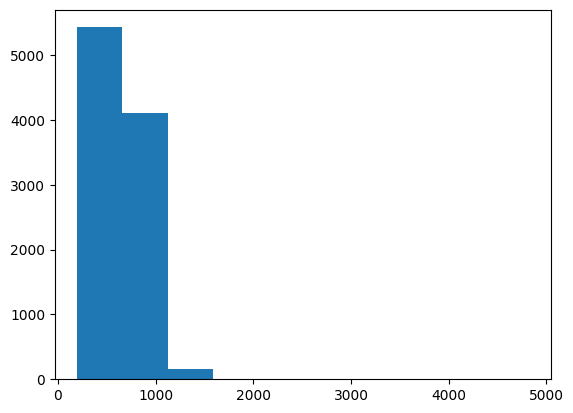

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lengths)
lengths.sort()

# 뒤에서 25번째면 몇일까?
print(lengths[-25])

# 얼추 1500의 길이를 기준으로 잘라내도록 한다.

In [ ]:
# 점수가 30점 만점으로 책정되어있는데, 점수를 30점 단위로 분류하면 너무 sparse 할 것을 예상할 수 있음.
# 따라서 점수를 1~5, 6~10과 같이 범위로 나누기로 한다. 1~5는 없어 총 5개의 분류가 된다.
train_dataset=[(i[0][0]['paragraph_txt'],(i[1]-1)//5) for i in train_dataset if len(i[0][0]['paragraph_txt'])<=1500]
val_dataset=[(i[0][0]['paragraph_txt'],(i[1]-1)//5) for i in val_dataset if len(i[0][0]['paragraph_txt'])<=1500]

(array([1.000e+00, 1.200e+01, 0.000e+00, 4.700e+01, 0.000e+00, 2.380e+02,
        9.960e+02, 0.000e+00, 2.992e+03, 5.404e+03]),
 array([-1. , -0.4,  0.2,  0.8,  1.4,  2. ,  2.6,  3.2,  3.8,  4.4,  5. ]),
 <BarContainer object of 10 artists>)

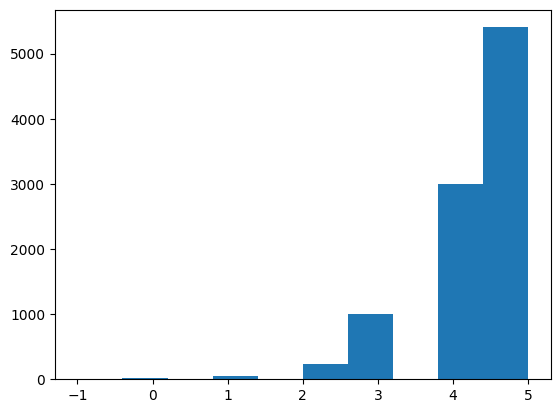

In [ ]:
# score의 분포를 확인해본다.
import matplotlib.pyplot as plt
scores=[i[1] for i in train_dataset]+[i[1] for i in val_dataset]
plt.hist(scores)

# **4. Model selection**
토이 프로젝트를 위해 새로운 모델 아키텍쳐를 만드는 것은 어렵습니다.

이번 과제에서는 huggingface에서 모델을 가져와 finetuning해보는 과제를 진행합니다.

중요한 것은 코랩/캐글 노트북으로 돌릴 수 있는 적절한 크기의 적절한 모델을 가져오는 것입니다.
못 돌릴 정도로 무거운 nlp 모델은 많지 않지만, 훈련 시간 등을 고려하면 가능하면 large라고 적혀 있는 model이나 generative model은 이용하지 않도록 합니다.

해당 토이 프로젝트에서는 koelectra를 이용했습니다.
(https://github.com/monologg/KoELECTRA/blob/master/README_EN.md)

In [ ]:
# 재현 가능성을 위해 random seed를 설정합니다.
random_seed=312
torch.manual_seed(random_seed)

# model과 tokenizer를 받아옵니다. 이 때, 종류에 맞는 형태로 가져오는 것이 중요합니다. ex) 글 점수 '분류' -> ElectraForSequenceClassification.from_pretrained
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator",num_labels=5,problem_type="multi_label_classification", output_attentions=True)
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
# classification task는 주로 label을 [0,1,0,0,0] 과 같은 one-hot encoding으로 처리해 줄 때가 많다.
# base label인 [0,0,0,0,0]에서 점수-1에 해당하는 index만 1로 만들어주자.
base=[0,0,0,0,0]
for i in range(len(train_dataset)):
    temp=base.copy()
    temp[train_dataset[i][1]-1]=1
    train_dataset[i]=(train_dataset[i][0],temp)

for i in range(len(val_dataset)):
    temp=base.copy()
    temp[val_dataset[i][1]-1]=1
    val_dataset[i]=(val_dataset[i][0],temp)

In [ ]:
# Dataset class를 설정해줘야 할 때고도, 설정해주지 않아도 될 때도 많다.
# 데이터 형식에 맞게 Dataset class를 정의해주자. .float32때문에 에러가 생길 때도 있으니 주의하자.
# Dataset class는 결국 나중에 모델에 data를 batch 단위로 전달하는 데 이용한다.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx],dtype=torch.float32).long() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx],dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# tokenizer()를 이용하여 전체 데이터셋을 한 번에 tokenizing 가능
train_encodings = tokenizer([i[0] for i in train_dataset], truncation=True, padding=True)
val_encodings = tokenizer([i[0] for i in val_dataset], truncation=True, padding=True)

In [ ]:
train_dataset = Dataset(train_encodings, [i[1] for i in train_dataset])
val_dataset = Dataset(val_encodings, [i[1] for i in val_dataset])

In [ ]:
# trainer 클래스를 이용할 것이다. 굉장히 편하고 간단하게 train 진행이 가능하다.
# training_args에 hyperparameter를 정의하면 된다.
# https://bo-10000.tistory.com/154
training_args = TrainingArguments(
    output_dir='dump',
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    gradient_accumulation_steps=4,
    save_total_limit=5,
    dataloader_num_workers=2,
    fp16=True,
    load_best_model_at_end=True,
    learning_rate=1e-4,
    report_to="wandb"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= train_dataset,
    eval_dataset = val_dataset
)

# **5. Train**
한 줄이면 끝이다.

In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: sbpark1. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.41009044647216797, 'eval_runtime': 17.8297, 'eval_samples_per_second': 53.731, 'eval_steps_per_second': 6.73, 'epoch': 1.0}
{'eval_loss': 0.39189428091049194, 'eval_runtime': 17.8378, 'eval_samples_per_second': 53.706, 'eval_steps_per_second': 6.727, 'epoch': 2.0}
{'eval_loss': 0.40941497683525085, 'eval_runtime': 17.8686, 'eval_samples_per_second': 53.614, 'eval_steps_per_second': 6.716, 'epoch': 3.0}
{'loss': 0.33, 'learning_rate': 7.034313725490197e-05, 'epoch': 3.66}
{'eval_loss': 0.4172805845737457, 'eval_runtime': 17.8339, 'eval_samples_per_second': 53.718, 'eval_steps_per_second': 6.729, 'epoch': 4.0}
{'eval_loss': 0.4668909013271332, 'eval_runtime': 17.8339, 'eval_samples_per_second': 53.718, 'eval_steps_per_second': 6.729, 'epoch': 5.0}
{'eval_loss': 0.4901515543460846, 'eval_runtime': 17.8735, 'eval_samples_per_second': 53.599, 'eval_steps_per_second': 6.714, 'epoch': 6.0}
{'eval_loss': 0.4767295718193054, 'eval_runtime': 17.8566, 'eval_samples_per_second': 53

TrainOutput(global_step=1360, training_loss=0.33425524655510397, metrics={'train_runtime': 4797.9218, 'train_samples_per_second': 18.2, 'train_steps_per_second': 0.283, 'train_loss': 0.33425524655510397, 'epoch': 9.96})

# **6. Inference**

In [ ]:
# 임의로 짧은 글을 넣어 inference를 해보자.
inputs = tokenizer('다음으로 좋은 친구를 사귀는 방법에 대해서 알아보자. 첫째, 달콤한 말, 행동 따위가 아닌 진정한 마음의 주인공을 사귀자. 아이스크림, 과자 등을 사준다거나 네가 정말 좋다고 말만 하는 아이가 좋은 친구는 아니다. 날 진심으로 좋아하고 위해주는 친구, 날 아껴주는 친구, 이런 친구가 좋은 친구인 것이다. 둘째, 내게 힘든 일이 생겼을 때 어려움을 무릅쓰고 도와줄 수 있는 친구를 사귀자. 평소에는 친하게 지내다가도 내가 어려움에 처했을 때는 외면해 버리는 그런 친구가 아닌, 날 위해 어려움을 무릅쓰고 도와줄 수 있는 그런 친구를 사귀어야 할 것이다.', return_tensors="pt")
inputs=inputs.to(device)
with torch.no_grad():
    output=model(**inputs)
    logits = output.logits
    attention=output[-1]
predicted_class_id = logits.argmax().item()
print("이 글은 "+str(predicted_class_id)+" 점입니다.")

3


**Q. 본인이 선정한 데이터셋과 선정한 이유가 무엇인지 간단히 적어주세요.**

**A.**

**Q. 본인이 선정한 주제를 간단히 적어주세요.**

**A.**

이제 직접 프로젝트를 동일한 과정으로 진행해 봅시다.

무엇이든 질문이 있다면, 카카오톡으로 박수빈에게 문의 주시거나 subin8636@naver.com으로 문의 주세요~